In [ ]:
import geopandas as gpd
import ee, eemont, geemap
import numpy as np
import pandas as pd

In [ ]:
def poly_to_fc(geodataframe):

    features = []

    gdf = geodataframe.explode().to_crs('EPSG:4326')

    for index, gdf_row in gdf.iterrows():
        
        geom = gdf_row.geometry 
        x, y = geom.exterior.coords.xy
        coords = np.dstack((x,y)).tolist()
        ee_geom = ee.Geometry.Polygon(coords)          
        feature = ee.Feature(ee_geom)

        features.append(feature)
                
    ee_fc = ee.FeatureCollection(features)

    return ee_fc

In [ ]:
try:
    fire_history_19_20 = gpd.read_file('fire_history_19_20/fire_history_19_20.shp')
except:
    fire_history = gpd.read_file('fire_history/fire_history.shp')
    fire_history_19_20 = fire_history[fire_history['fih_fire_s'] == '2019/2020']
    fire_history_19_20.to_file('fire_history_19_20/fire_history_19_20.shp')
    fire_history_19_20 = gpd.read_file('fire_history_19_20/fire_history_19_20.shp')


<AxesSubplot:>

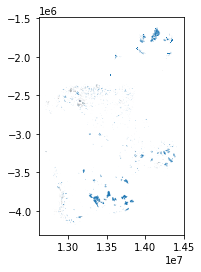

In [ ]:
fire_history_19_20.plot()

In [ ]:
fire_history_19_20.head(5)

,fih_fire_s,fih_year1,fih_season,fih_distri,fih_hist_d,fih_number,fih_fire_t,fih_date1,fih_cause,fih_ignit_,...,fih_poly_t,fih_commen,fih_name,fih_burn_p,fih_master,fih_perime,fih_hectar,Shape_Leng,Shape_Area,geometry
0,2019/2020,2020,AU,BWD,Blackwood,BF 2019 BWD 038,WF,2020-02-26,7,0,...,Actual Burnt,"DFES No. 468486, Lightning strike reported thr...",Locke NR,0,0,0.111960,0.099493,134.697819,1440.135314,"POLYGON ((12826960.383 -3984386.955, 12826964...."
1,2019/2020,2020,AU,SWC,Swan Coastal,BF 2019 SWC 098,WF,2020-02-26,7,0,...,Actual Burnt,"DFES No. 468478, Likely Lighting strike fire n...",Panorama Dr Preston Beach,0,0,0.111959,0.099493,133.405120,1412.625483,"POLYGON ((12876396.017 -3871063.533, 12876399...."
2,2019/2020,2020,AU,BWD,Blackwood,BF 2019 BWD 039,WF,2020-02-26,7,0,...,Actual Burnt,"DFES No. 468491, Lightning strike",Treeton North Rd,0,0,0.354294,0.997660,427.058304,14496.124600,"POLYGON ((12816885.340 -4006414.447, 12816893...."
3,2019/2020,2020,AU,BWD,Blackwood,BF 2019 BWD 040,WF,2020-02-26,7,0,...,Actual Burnt,"DFES No. 468493, Lightning strike",Quindalup Siding,0,0,0.111960,0.099493,134.651593,1439.147150,"POLYGON ((12819298.623 -3980486.479, 12819302...."
4,2019/2020,2020,AU,BWD,Blackwood,BF 2019 BWD 041,WF,2020-02-26,7,0,...,Actual Burnt,"DFES No. 468496, Lightning strike",Bunker Bay Rd,0,0,0.111960,0.099493,134.517717,1436.286875,"POLYGON ((12805612.606 -3968844.779, 12805616...."


In [ ]:
def get_index_frame(shapefile, collection):

    for index, gdf_row in shapefile.iterrows():

        gdf = poly_to_fc(shapefile)
        peak_winter = '2019-07-31'
        fire_date = gdf_row.fih_date1

        ee_col = (ee.ImageCollection(collection)
            .filterBounds(gdf)
            .filterDate(peak_winter, fire_date)
            .index(['EVI','NBRT']))

        ts = ee_col.getTimeSeriesByRegion(reducer = ee.Reducer.mean(),
                                          geometry = gdf,
                                          bands = ['EVI','NBRT'],
                                          scale = 250,
                                          dateFormat = 'YYYY-MM-dd')

        ts_pandas = geemap.ee_to_pandas(ts)
        ts_pandas[ts_pandas == -9999] = np.nan
        ts_pandas['date'] = pd.to_datetime(ts_pandas['date'],
                                           infer_datetime_format = True)

        return ts_pandas
